# Загрузка и первичная обработка данных. EDA
## Автор: Нюнин Николай
### 1. Импорт необходимых библиотек

In [1]:
import os

import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

### 2. Загрузка датасета

In [2]:
# атрибуты моделей автомобилей
attributes = pd.read_table('../data/CompCars/data/misc/attributes.txt', sep=' ')
attributes.head()

,model_id,maximum_speed,displacement,door_number,seat_number,type
0,1,235,1.8,5,5,4
1,2,220,1.8,4,5,3
2,3,228,2.0,4,5,3
3,4,230,2.0,5,5,2
4,5,234,3.0,5,5,2


In [3]:
models_and_types = attributes.drop(['maximum_speed', 'displacement', 'door_number', 'seat_number'], axis=1)
models_and_types.set_index('model_id', inplace=True)
models_and_types.head()

,type
model_id,
1,4
2,3
3,3
4,2
5,2


In [4]:
# словарь для получения типа автомобиля по его модели
MODEL_TO_TYPE = models_and_types.to_dict('index')

In [5]:
def type_from_model(model_id: int) -> int:
    """Получить id типа автомобиля по его id модели."""

    return MODEL_TO_TYPE[model_id]['type']

In [6]:
def load_dataset() -> pd.DataFrame:
    """Загрузить датасет."""

    rows = []

    images_path = '..\\data\\CompCars\\data\\image'  # путь до изображений
    for dirpath, _, filenames in tqdm(os.walk(images_path)):
        for filename in filenames:
            model_id = int(dirpath.split('\\')[-2])
            label_path = os.path.join(dirpath.replace('image', 'label'), filename.replace('jpg', 'txt'))
            with open(label_path) as label_file:
                x1, y1, x2, y2 = [int(coord) for coord in label_file.readlines()[2].split()]
            rows.append({
                'file_path': os.path.join(dirpath, filename),
                'x1': x1,
                'y1': y1,
                'x2': x2,
                'y2': y2,
                'type': type_from_model(model_id)
            })

    return pd.DataFrame(rows)

In [7]:
# загрузка датасета
df = load_dataset()

6335it [00:32, 194.40it/s]


### 3. Обработка типов кузова автомобилей

In [8]:
# оригинальные названия типов автомобилей
OLD_TYPE_NAMES = ['MPV', 'SUV', 'sedan', 'hatchback', 'minibus', 'fastback', 'estate', 'pickup', 'hardtop convertible', 'sports', 'crossover', 'convertible']

In [9]:
# новые названия типов автомобилей
NEW_TYPE_NAMES = ['minivan', 'SUV', 'sedan', 'hatchback', 'minibus', 'fastback', 'estate', 'pickup', 'convertible', 'sports']

In [10]:
# список для конвертации типов автомобилей
OLD_TO_NEW_TYPES = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 2, 9]

<Axes: xlabel='type'>

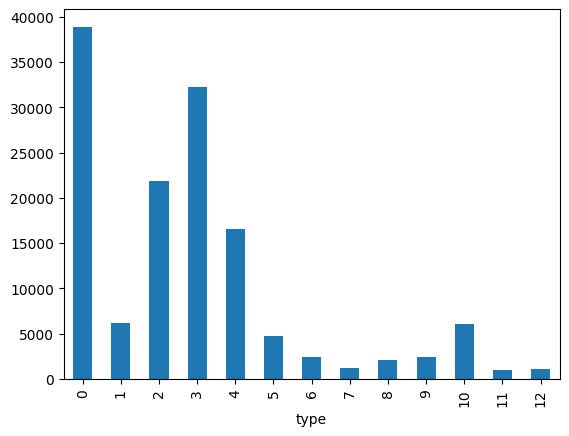

In [11]:
# изначальное распределение по типам кузова
df.groupby('type').size().plot(kind='bar')

In [12]:
# удаление автомобилей без данных о типе
df = df.drop(df[df['type'] == 0].index)

In [13]:
# конвертация типов
df['type'] = df.apply(lambda row: OLD_TO_NEW_TYPES[row['type']], axis=1)

In [14]:
# добавление названий типов
df['type_name'] = df.apply(lambda row: NEW_TYPE_NAMES[row['type'] - 1], axis=1)

In [15]:
df.head()

,file_path,x1,y1,x2,y2,type,type_name
149,..\data\CompCars\data\image\100\209\2009\0ff9e...,95,85,817,626,1,minivan
150,..\data\CompCars\data\image\100\209\2009\10359...,223,163,704,548,1,minivan
151,..\data\CompCars\data\image\100\209\2009\1cb89...,95,100,849,606,1,minivan
152,..\data\CompCars\data\image\100\209\2009\35bc7...,54,137,837,613,1,minivan
153,..\data\CompCars\data\image\100\209\2009\398aa...,96,203,794,531,1,minivan


### 4. EDA
#### 4.1 Анализ числа объектов по классам

In [16]:
# вычисление распределений автомобилей по классам
df.groupby('type_name').agg({'type_name': 'count'})

,type_name
type_name,
SUV,22752
convertible,3520
estate,1215
fastback,2473
hatchback,16573
minibus,4729
minivan,6149
pickup,2134
sedan,32274


In [17]:
# общее число изображений
len(df)

97842

<Axes: xlabel='type_name'>

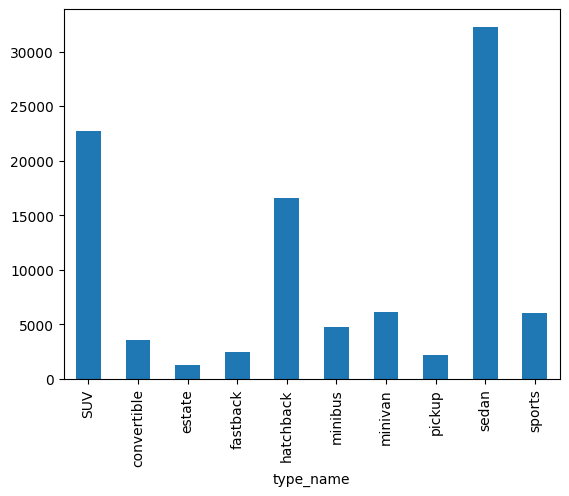

In [18]:
# визуализация распределений автомобилей по классам
df.groupby('type_name').size().plot(kind='bar')

#### 4.2 Анализ размера bounding box'ов

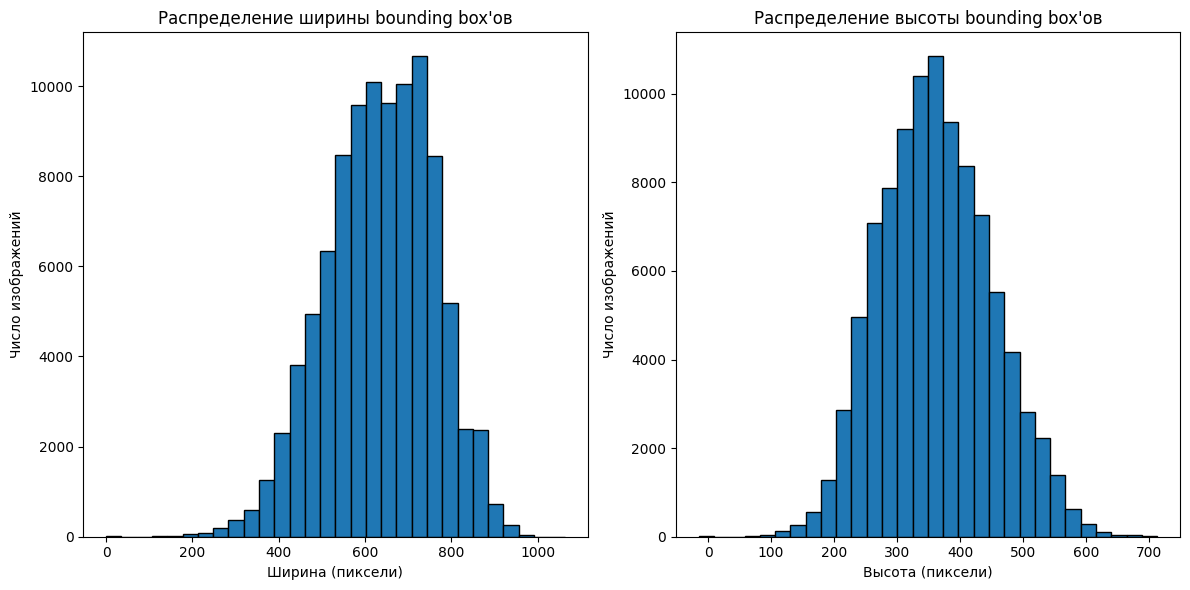

In [19]:
df['bbox_width'] = df['x2'] - df['x1']
df['bbox_height'] = df['y2'] - df['y1']

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(df['bbox_width'], bins=30, edgecolor='black')
plt.title("Распределение ширины bounding box'ов")
plt.xlabel('Ширина (пиксели)')
plt.ylabel('Число изображений')

plt.subplot(1, 2, 2)
plt.hist(df['bbox_height'], bins=30, edgecolor='black')
plt.title("Распределение высоты bounding box'ов")
plt.xlabel('Высота (пиксели)')
plt.ylabel('Число изображений')

plt.tight_layout()
plt.show()